In [ ]:
!pip install einops > /dev/null
import torch
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import scipy.ndimage as nd
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import tensorflow as tf
#from tensorflow.keras import layers, models
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA

from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
import os
import glob
import PIL
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import einops
import torch.nn.functional as fonctional
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader

In [ ]:
#Install appropriate open cv libraries
!pip install opencv-python==3.4.2.17  
!pip install opencv-contrib-python==3.4.2.17


# Reading the required Data

In [ ]:

def get_cifar10_dataloaders(val_percentage=0.1, batch_size=20):
  input_size = 32

  transform_test = transforms.Compose(
    [transforms.Resize(input_size),
     transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
  
  transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                        #transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(5),
                        transforms.RandomRotation(7),
                        transforms.Resize(input_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

  dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train) #len=50000

  dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test) #len=10000

  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train

  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])

  data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)

  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)

  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)

  return data_loader_train, data_loader_val, data_loader_test

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# _ = get_cifar10_dataloaders()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


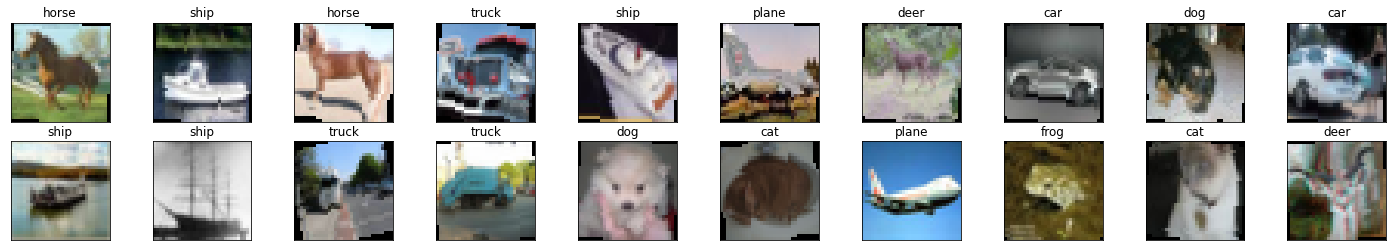

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image /2 + 0.5     # unnormalize
  image = image.transpose(1, 2, 0)
  return image

a,_,_=get_cifar10_dataloaders( batch_size=40)
dataiter = iter(a)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

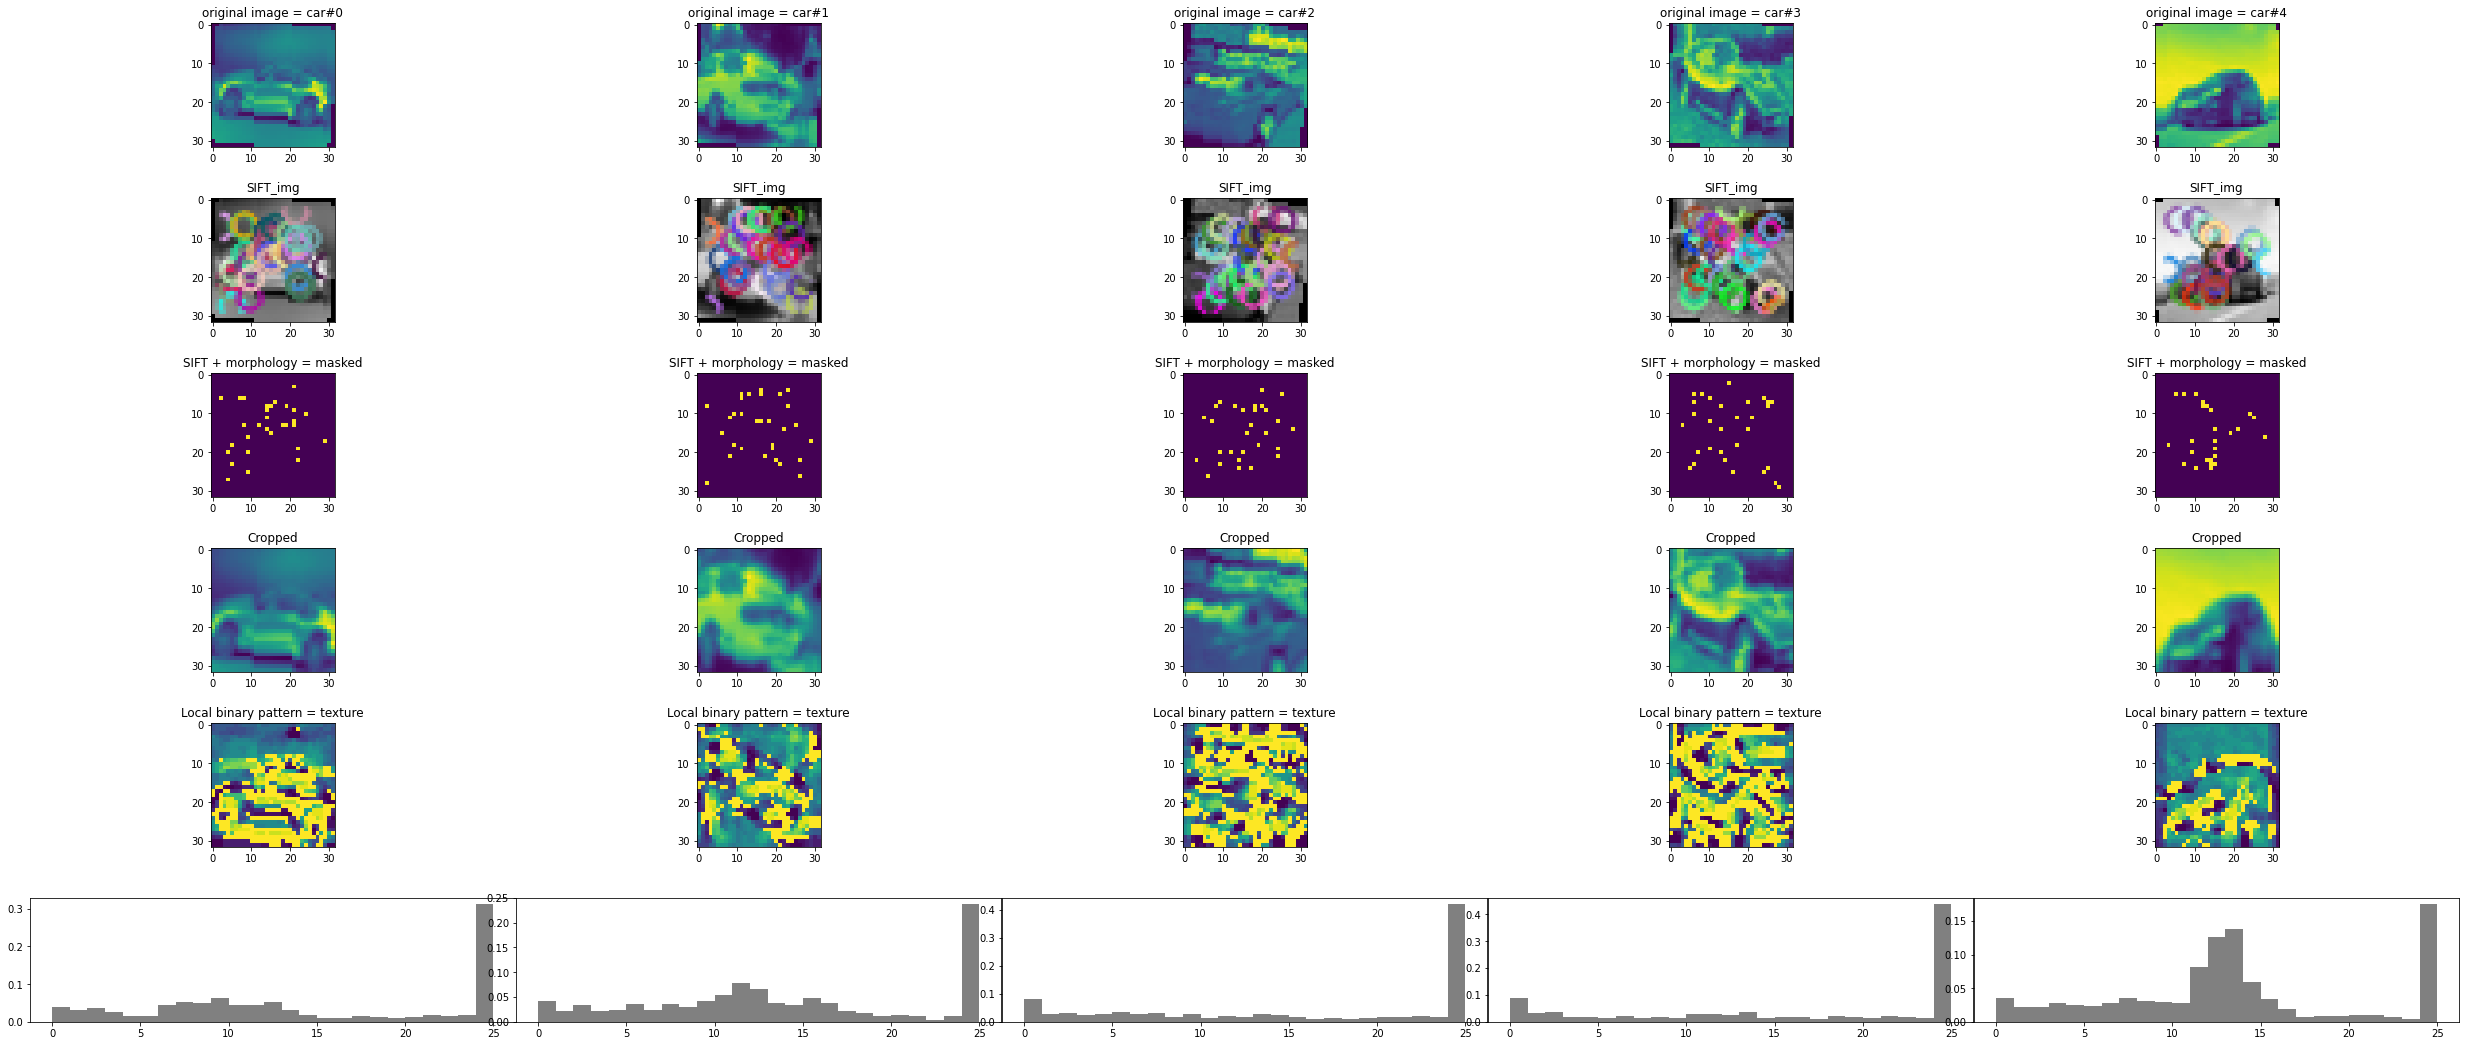

In [ ]:

radius = 3
n_points = 8*radius
METHOD = 'uniform'
item_name='car'
item = classes.index(item_name)
idx=list(range(images[labels==item].shape[0]))
fig, ax = plt.subplots(6,len(idx), figsize=(35,15))
fig.tight_layout(pad=3.0)
fig.subplots_adjust(wspace=0.001)

t=0
  #
for i in idx:
  
  contrast = images[labels==item][i].std()
  img=cv2.normalize(np.array(images[labels==item][i]), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U).transpose(1, 2, 0)
  image_repr = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast)
  keypoints_1, descriptors_1 = sift.detectAndCompute(image_repr,None)

  imgtemp = cv2.drawKeypoints(image_repr,keypoints_1,image_repr)
  kp = np.array([k.pt for k in keypoints_1]).astype(int)
  temp = np.zeros_like(image_repr)
  for j in kp:
    temp[j[1],j[0]] = 255
  closing = nd.binary_closing(temp,iterations=1).astype(int)
  sl = np.where(closing == 1)[0].min()
  el = np.where(closing == 1)[0].max()
  sc = np.where(closing == 1)[1].min()
  ec = np.where(closing == 1)[1].max()
  cropped = cv2.resize(image_repr[sl:el,sc:ec],dsize=(32,32))
  lbp = local_binary_pattern(cropped, n_points, radius, METHOD)
  
  ax[0][t].imshow(image_repr)
  ax[0][t].set_title("original image = " + item_name + '#'+str(i))
  ax[1][t].imshow(imgtemp)
  ax[1][t].set_title("SIFT_img")
  ax[2][t].imshow(closing)
  ax[2][t].set_title("SIFT + morphology = masked")
  ax[3][t].imshow(cropped)
  ax[3][t].set_title("Cropped")
  
  ax[4][t].imshow(lbp)
  ax[4][t].set_title("Local binary pattern = texture")
  n_bins = int(lbp.max())
  ax[5][t].hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')
  t = t+1
    

In [ ]:
def feature_xtr(image):
  img=cv2.normalize(np.array(image), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U).transpose(0,2, 3, 1)
  x_mask = np.zeros_like(img[:,:,:,-1])
  x_masked = np.zeros_like(img[:,:,:,-1])
  x_cropped = []
  X = []
  Xi = []
  xi_masked = []
  xi_cropped = []
  # for i in tqdm(range(int(len(img)))):
  for i in range(int(len(img))):
    image_repr = cv2.cvtColor(img[i], cv2.COLOR_RGB2GRAY)
    X.append(image_repr)
    contrast = image_repr.std()
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast) #
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_repr,None)
    kp = np.array([i.pt for i in keypoints_1]).astype(int)
    for j in kp:
      x_mask[i, j[1],j[0]] = 255
    x_mask[i] = nd.binary_closing(x_mask[i]).astype(int)
    x_masked[i] = (x_mask[i])*image_repr
    if (x_mask[i].max(axis=1).max()==1 and x_mask[i].max(axis=0).max()==1):
      sl = np.where(x_mask[i] == 1)[0].min()
      #print(sl)
      el = np.where(x_mask[i] == 1)[0].max()
      #print(el)
      sc = np.where(x_mask[i] == 1)[1].min()
      #print(sc)
      ec = np.where(x_mask[i] == 1)[1].max()
      #print(ec)

      if (sl!=el and sc!=ec):
        x_cropped.append(cv2.resize(image_repr[sl:el,sc:ec],dsize=(32,32)))
      else:
        x_cropped.append(image_repr)
    else:
      x_cropped.append(image_repr)

  # for i in tqdm(range(len(image))):
  for i in range(len(image)):
    Xi.append(cv2.resize(X[i], dsize=(299,299)))
    xi_masked.append(cv2.resize(x_masked[i], dsize=(299,299)))
    xi_cropped.append(cv2.resize(x_cropped[i], dsize=(299,299)))
  # X=np.array(X)
  # x_masked=np.array(x_masked)
  # x_cropped=np.array(x_cropped)
  Xtr = np.stack([Xi, xi_masked, xi_cropped], axis=-1)

  return Xtr



In [ ]:
class Experiment:

    def __init__(self,model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.cuda()
        self.optimizer = None
        self.scheduler = None
        

        self.criterion = torch.nn.CrossEntropyLoss().cuda() if self.use_cuda else torch.nn.MSELoss()
        self.train_losses = []
        self.train_accs = []
        self.train_f1_log = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1_log = []
        self.start_epoch = 1

    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       

        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=1, verbose=True)
        
        best_val_f1 = 0.4

        for epoch in range(self.start_epoch, num_epochs + 1):

            print('Epoch {}/{}'.format(epoch, num_epochs))

            epoch_losses = []
            epoch_accs = []
            epoch_f1 = []
            i = 0
            if verbose :
              pbar = tqdm(train_data_loader)
            else :
              pbar = train_data_loader
            for data in pbar:

                images,labels  = data
                images=torch.from_numpy(feature_xtr(images).transpose(0,3,1,2))             #################################### added
                images = images.float()
                labels = labels.to(self.device)
                images = images.to(self.device)
                

                self.optimizer.zero_grad()

                outputs = self.model.forward(images)

                loss = self.criterion(outputs, labels)
                loss.backward()

                self.optimizer.step()

                epoch_losses.append(loss.data.cpu())
                
                batch_accuracy = accuracy(outputs, labels)

                epoch_accs.append(batch_accuracy) 
                batch_f1 = f1_score_(outputs, labels)
                epoch_f1.append(batch_f1) 

                if verbose:
                  pbar.set_postfix({"Batch loss ":loss.data.cpu().numpy(),' Epoch loss ': np.mean(epoch_losses)," Batch Acc ":batch_accuracy.numpy()," Epoch Acc ":np.mean(epoch_accs),
                                    " Batch f1 ":batch_f1,"  Avg Epoch f1 ":np.mean(epoch_f1)})   

            self.train_losses.append(np.mean(epoch_losses))
            self.train_accs.append(np.mean(epoch_accs))
            self.train_f1_log.append(np.mean(epoch_f1))



            if validate_each_epoch:
                val_loss,val_acc,val_f1= self.validate(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc) 
                self.val_f1_log.append(val_f1) 
                if verbose:  
                  print("Val loss : ",val_loss,' Val Acc : ',val_acc," Val f1 : ",val_f1)   
            
            #Lr scheduler
            self.scheduler.step(np.mean(epoch_losses))


            if val_f1 > best_val_f1 :
              self.save_parameters(model_name+" "+str(val_f1.round(2)), save_dir,epoch)
              best_val_f1 = val_f1




    def validate(self,data_loader):
        
        self.model.eval()
        losses = []
        predictions = []
        y_val = []
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images=torch.from_numpy(feature_xtr(images).transpose(0,3,1,2))             #################################### added
                images = images.float()
                labels = labels.to(self.device)
                images = images.to(self.device)
                
                outputs = self.model.forward(images)
                loss = self.criterion(outputs, labels)
                losses.append(loss.data.cpu())
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_val.extend(list(labels.view(-1).cpu().numpy()))

        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions,average='micro')

        self.model.train()
        
        return np.mean(losses),acc,f1




    def predict_loader(self,data_loader):
        self.model.eval()
        predictions = []
        y_true=[]

        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images=torch.from_numpy(feature_xtr(images).transpose(0,3,1,2))             #################################### added
                images = images.float()
                images = images.to(self.device)
                
                outputs = self.model.forward(images)
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_true.extend(list(labels.view(-1).cpu().numpy()))

        self.model.train()
        return predictions,y_true
    
    def save_parameters(self,model_name, directory,epoch):
        """Saves the parameters of the network to the specified directory.

        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))

    def load_parameters(self, path):
        """Loads the given set of parameters.

        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']

    def plot(self):

      fig, axes = plt.subplots(3, 1, figsize = (10,10))

      train_losses = np.array(self.train_losses)
      val_losses  = np.array(self.val_losses)
      axes[0].plot(train_losses, label = "training loss")
      axes[0].plot(val_losses, label = "val loss")
      axes[0].set_title('loss variation during training', fontsize = 8)
      axes[0].legend()


      train__accs = np.array(self.train_accs)
      val_accs  = np.array(self.val_accs)
      axes[1].plot(train__accs, label = "training accuracy")
      axes[1].plot(val_accs, label = "val accuracy")
      axes[1].set_title('accuracy variation during training', fontsize = 8)
      axes[1].legend()



      train_f1_log = np.array(self.train_f1_log)
      val_f1_log  = np.array(self.val_f1_log)
      axes[2].plot(train_f1_log, label = "training f1 score")
      axes[2].plot(val_f1_log, label = "val f1 score")
      axes[2].set_title('f1 score variation during training', fontsize = 8)
      axes[2].legend()

      plt.show()



      
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


from sklearn.metrics import f1_score,accuracy_score

def f1_score_(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return f1_score(preds.detach().cpu().numpy(), labels.cpu().numpy(), average='micro')

In [ ]:
#https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

class SeparableConv(nn.Module):
  """
  Modified and Xception-adapted version of the depthwise seperable convolution.
  It's basically a depthwise spacial convolution followed by a pointwise convolution.
  For a resulting outpout that we will call the SeperableConv.
  """
  def __init__(self, inputs, outputs,**kwargs):
        super().__init__()
        #majuscule utiliser pour le ouput de notre architecture a la fin qui est plus regulier
        #first depthwise spacial convolution
        self.DepthwiseConv = nn.Conv2d(
            inputs, 
            inputs, 
            3, 
            padding=1, 
            groups=inputs, 
            bias=False,
            **kwargs)
        
        #pointwise convolution
        self.PointwiseConv = nn.Conv2d(
            inputs, 
            outputs, 
            1, 
            bias=False,
            **kwargs)

  def forward(self, x):
        depthwise = self.DepthwiseConv(x)
        outpout = self.PointwiseConv(depthwise)
        return outpout

In [ ]:
#some of the variables names will have a  UpperCase on the variables first letters to have a final architecture that will follow the same etiquettes as in torch.nn

class Entryflow(nn.Module):
    """
    This first flow will containt 4 blocs with a total of 2 convolutional layers,
    6 seperable convolutional layers and 3 skip-connections (shortcuts). ALl the activations will be Relu.
    Other than bloc1, all other 3 will have a MaxPooling Layer.
    """
    def __init__(self, input):

        super().__init__()
        #first bloc with the conv32 &conv 64 (see picture above of architecture)
        self.bloc1 = nn.Sequential(
            nn.Conv2d(input, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) 

        #seperableconv 128 followed by another seperableconv 138
        self.bloc2 = nn.Sequential(

            SeparableConv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            

            SeparableConv(128, 128),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection1 = nn.Conv2d(64, 128, 1, 2, 0)

        #seperable conv 256 (x2)
        self.bloc3 = nn.Sequential(
            nn.ReLU(inplace=True),
            
            SeparableConv(128, 256),
            nn.BatchNorm2d(256),
            
            nn.ReLU(inplace=True),

            SeparableConv(256, 256),
            nn.BatchNorm2d(256),
            
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection2 = nn.Conv2d(128, 256, 1, 2, 0)
        
        #separableconv 728 (x2))
        self.bloc4 = nn.Sequential(
            nn.ReLU(inplace=True),

            SeparableConv(256, 728),            
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.MaxPool2d(3, 2, 1)
        )
        #skip connection conv 1x1
        self.SkipConnection3 = nn.Conv2d(256, 728, 1, 2, 0)

    def forward(self, x):
      #do the 4 blocs +residuals :

        bloc1 = self.bloc1(x)
        bloc2_res = self.bloc2(bloc1) + self.SkipConnection1(bloc1)

        bloc3_res= self.bloc3(bloc2_res) + self.SkipConnection2(bloc2_res)
        out = self.bloc4(bloc3_res) + self.SkipConnection3(bloc3_res)
        return out
    

In [ ]:
class Middleflow(nn.Module):
    """
    This 2nd flow (the easiest one to understand) is a 3 times repetition of a separable conv with a relu activation
    """
    def __init__(self):

        super().__init__()
        # 3 times a separable conv with relu activation
        self.bloc8 = nn.Sequential(
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),            
                        
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728)
        )

    def forward(self, x):

        #we repeat the bloc 8 times like it is displayed in the picture of the architecture
        for i in range(8):
          x = self.bloc8(x) + x
        out=x
        return out


In [ ]:
class Exitflow(nn.Module):
    """
    This is the 3rd and final flow of the Xception architecture. It will have 2 blocs, one with 2 seperable conv with an addition of a skip-connection.
    Anothr bloc will contain 2 seperable conv and a global average pool.
    Finally we will have a fully connected  layer form a 2048-dimensional vectors + logicstic regression.
    """
    def __init__(self, classes):
        super().__init__()

        # BLoc 1 :two seperableconv : 728 followed by a 1024
        self.bloc1 = nn.Sequential(
            nn.ReLU(inplace=True),

            SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace=True),

            SeparableConv(728, 1024),
            nn.BatchNorm2d(1024),
            
            nn.MaxPool2d(3, 2, 1)
        )

        #skip-connection of conv from bloc 1
        self.SkipConnection = nn.Conv2d(728, 1024, 1, 2, 0)
        
        #2nd bloc with only 2 seperableconv of 1536 and 2048.
        self.bloc2 = nn.Sequential(

            SeparableConv(1024, 1536),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            

            SeparableConv(1536, 2048),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )

        #majuscule pour larchitecture finale du fullyconnected layer

        #fully connected last layer
        self.FullyConnectedLayer = nn.Linear(2048, classes)
    def forward(self, x):
        x = self.bloc1(x) + self.SkipConnection(x)
        x = self.bloc2(x)
        #avg pool
        avg_pool = fonctional.adaptive_avg_pool2d(x, output_size=(1, 1))                
        global_avg_pool = avg_pool.view(avg_pool.size(0), -1)

        out = self.FullyConnectedLayer(global_avg_pool)
        
        return out  

In [ ]:
class Xception(nn.Module):
    def __init__(self, input, classes):
      super().__init__()
      #merging all 3 of the flows into creating the overall architecture of the Xception model
      self.entry=Entryflow(input)
      self.middle=Middleflow()
      self.exit=Exitflow(classes)
      
      # add logistic regression ???? 

    def forward(self,x):

      entry_flow= self.entry(x)
      middle_flow=self.middle(entry_flow)
      out=self.exit(middle_flow)

      return out

In [ ]:
net = Xception(3, 10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


exp_2 = Experiment(net)

for param in exp_2.model.parameters():
    param.requires_grad = True

In [ ]:
train_loader, validation_loader, test_loader=get_cifar10_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# %%timeit
exp_2.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model_xception_',
                        num_epochs=10,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)

Epoch 1/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  1.2733103  Val Acc :  0.5534  Val f1 :  0.5534
Epoch 2/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  1.0486985  Val Acc :  0.632  Val f1 :  0.632
Epoch 3/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.8210123  Val Acc :  0.7072  Val f1 :  0.7072
Epoch 4/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.7179418  Val Acc :  0.7462  Val f1 :  0.7461999999999999
Epoch 5/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.72697425  Val Acc :  0.7584  Val f1 :  0.7584000000000001
Epoch 6/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.62663734  Val Acc :  0.7874  Val f1 :  0.7874
Epoch 7/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5803231  Val Acc :  0.7992  Val f1 :  0.7992
Epoch 8/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5835175  Val Acc :  0.7986  Val f1 :  0.7986
Epoch 9/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5799857  Val Acc :  0.8056  Val f1 :  0.8056000000000001
Epoch 10/10


  0%|          | 0/2250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Val loss :  0.5196516  Val Acc :  0.8202  Val f1 :  0.8202


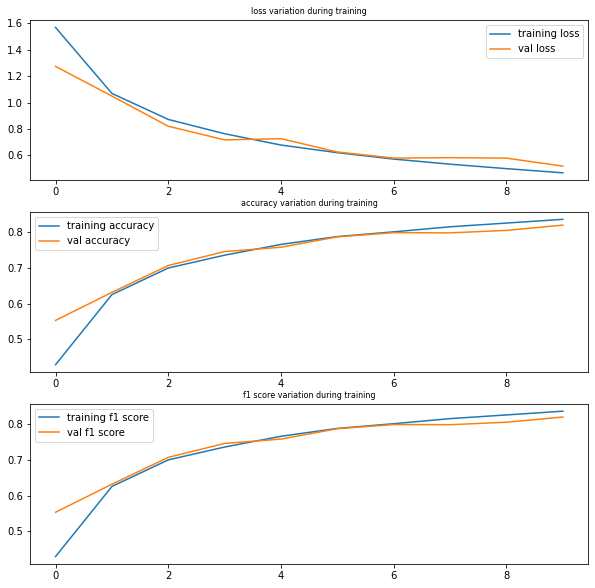

In [ ]:
exp_2.plot()

In [ ]:
#With SIFT
exp_2.validate(test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

(0.46759894, 0.8404, 0.8404)

  0%|          | 0/500 [00:00<?, ?it/s]

f1 score :  0.8404999999999999
              precision    recall  f1-score   support

       plane       0.83      0.88      0.86      1000
         car       0.93      0.91      0.92      1000
        bird       0.78      0.75      0.76      1000
         cat       0.68      0.76      0.72      1000
        deer       0.81      0.81      0.81      1000
         dog       0.82      0.77      0.79      1000
        frog       0.94      0.80      0.86      1000
       horse       0.89      0.90      0.89      1000
        ship       0.96      0.86      0.91      1000
       truck       0.82      0.97      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



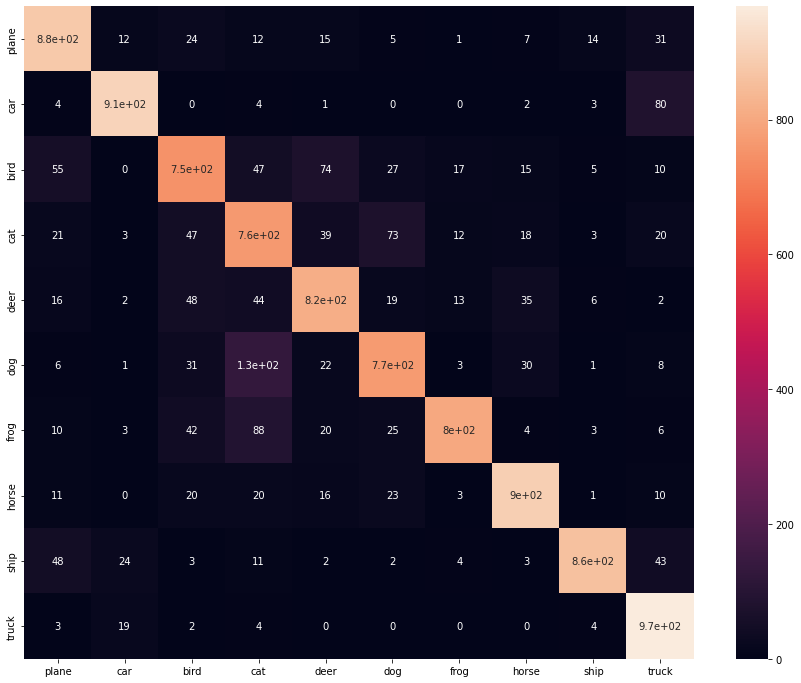

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat,y_true = exp_2.predict_loader(test_loader)
#y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(classes)))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(classes)],
                      columns = [i for i in list(classes)])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)